# nuScenes RADAR velocity estimation

This jupyter notebook assumes the database itself is available at `/data/sets/nuscenes`, and loads a mini version of the full dataset.

## A Gentle Introduction to nuScenes

For backgroud information, the nuScenes dataset comprises of elemental building blocks that are the following:

1. `log` - Log information from which the data was extracted.
2. `scene` - 20 second snippet of a car's journey.
3. `sample` - An annotated snapshot of a scene at a particular timestamp.
4. `sample_data` - Data collected from a particular sensor.
5. `ego_pose` - Ego vehicle poses at a particular timestamp.
6. `sensor` - A specific sensor type.
7. `calibrated sensor` - Definition of a particular sensor as calibrated on a particular vehicle.
8. `instance` - Enumeration of all object instance we observed.
9. `category` - Taxonomy of object categories (e.g. vehicle, human). 
10. `attribute` - Property of an instance that can change while the category remains the same.
11. `visibility` - Fraction of pixels visible in all the images collected from 6 different cameras.
12. `sample_annotation` - An annotated instance of an object within our interest.
13. `map` - Map data that is stored as binary semantic masks from a top-down view.

The database schema is visualized below. For more information see the [nuScenes schema](https://github.com/nutonomy/nuscenes-devkit/blob/master/docs/schema_nuscenes.md) page.
![](https://www.nuscenes.org/public/images/nuscenes-schema.svg)

## Google Colab (optional)

<br>
<a href="https://colab.research.google.com/github/nutonomy/nuscenes-devkit/blob/master/python-sdk/tutorials/nuscenes_tutorial.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left">
</a>
<br>

If you are running this notebook in Google Colab, you can uncomment the cell below and run it; everything will be set up nicely for you. Otherwise, manually set up everything.

In [1]:
# !mkdir -p /data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.

# !wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

# !tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.

# !pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

## Initialization

In [2]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.635 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
from nuscenes.utils.data_classes import RadarPointCloud
from nuscenes.utils.geometry_utils import points_in_box
import numpy as np
from tabulate import tabulate
from pyquaternion import Quaternion

# LiDAR & RADAR point cloud manipulation #

## Determining amount of points within a detected object

### LiDAR

In [4]:
### WORKING LIDAR! ###

# Get token for sensor and annotations
my_sample = nusc.sample[0]
lidar_token = my_sample['data']['LIDAR_TOP']
anns = my_sample['anns']

# Test for each individual box
i = 0 # Box being tested
for ann_token in anns:

    # Get path in which point cloud info is stored (pc_path) and geometric information of all bounding boxes within the frame (boxes) 
    pc_path, boxes, _ = nusc.get_sample_data(lidar_token, selected_anntokens=[ann_token])

    # Load LiDAR points from retrieved path and reshape due to 5 channels
    pc = np.fromfile(pc_path, dtype=np.float32).reshape(-1, 5)  # LiDAR point cloud (x, y, z, intensity, ring index)
    # print(pc.shape)
    
    # Transpose LiDAR points to shape (3, N)
    points = pc[:, :3].T 
    print(points.shape)
    # See which points are within the box (outputs bolean mask with true for points which are within the box)
    points_inside = points_in_box(boxes[0], points)  # Now points is (3, N)

    # Print calculated and true number of points which are 
    print(f"Number of points inside box {i}: Calculated: {np.sum(points_inside)}; Ground truth: {nusc.get('sample_annotation', ann_token)['num_lidar_pts']}")

    i+=1 # Test next box

### WORKING LIDAR! ###

(3, 34688)
Number of points inside box 0: Calculated: 1; Ground truth: 1
(3, 34688)
Number of points inside box 1: Calculated: 2; Ground truth: 2
(3, 34688)
Number of points inside box 2: Calculated: 5; Ground truth: 5
(3, 34688)
Number of points inside box 3: Calculated: 1; Ground truth: 1
(3, 34688)
Number of points inside box 4: Calculated: 1; Ground truth: 1
(3, 34688)
Number of points inside box 5: Calculated: 1; Ground truth: 1
(3, 34688)
Number of points inside box 6: Calculated: 1; Ground truth: 1
(3, 34688)
Number of points inside box 7: Calculated: 45; Ground truth: 45
(3, 34688)
Number of points inside box 8: Calculated: 1; Ground truth: 1
(3, 34688)
Number of points inside box 9: Calculated: 4; Ground truth: 4
(3, 34688)
Number of points inside box 10: Calculated: 77; Ground truth: 77
(3, 34688)
Number of points inside box 11: Calculated: 7; Ground truth: 7
(3, 34688)
Number of points inside box 12: Calculated: 6; Ground truth: 6
(3, 34688)
Number of points inside box 13: C

### RADAR (1 sensor only)

In [5]:
### WORKING RADAR ONLY 1 RADAR SENSOR! ###

# Get token for sensor and annotations
my_sample = nusc.sample[0]
radar_token = my_sample['data']['RADAR_FRONT']
anns = my_sample['anns']

# Test for each individual box
i = 0 # Box being tested
for ann_token in anns:

    # Get path in which point cloud info is stored (pc_path) and geometric information of all bounding boxes within the frame (boxes) 
    pc_path, boxes, _ = nusc.get_sample_data(radar_token, selected_anntokens=[ann_token])

    # Load RADAR points from retrieved path and reshape due to 5 channels
    pc = RadarPointCloud.from_file(pc_path).points
    # Extract only xyz coordinates
    points = pc[:3, :]  # Shape (3, N), already transposed in RadarPointCloud 

    # See which points are within the box (outputs bolean mask with true for points which are within the box)
    points_inside = points_in_box(boxes[0], points)  # Now points is (3, N)

    # Print calculated and true number of points which are 
    print(f"Number of points inside box {i}: Calculated: {np.sum(points_inside)}; Ground truth: {nusc.get('sample_annotation', ann_token)['num_radar_pts']}")

    i+=1 # Test next box

### WORKING RADAR ONLY 1 RADAR SENSOR! ###

Number of points inside box 0: Calculated: 0; Ground truth: 0
Number of points inside box 1: Calculated: 0; Ground truth: 0
Number of points inside box 2: Calculated: 0; Ground truth: 0
Number of points inside box 3: Calculated: 0; Ground truth: 0
Number of points inside box 4: Calculated: 0; Ground truth: 0
Number of points inside box 5: Calculated: 0; Ground truth: 0
Number of points inside box 6: Calculated: 0; Ground truth: 0
Number of points inside box 7: Calculated: 0; Ground truth: 6
Number of points inside box 8: Calculated: 0; Ground truth: 0
Number of points inside box 9: Calculated: 2; Ground truth: 2
Number of points inside box 10: Calculated: 0; Ground truth: 0
Number of points inside box 11: Calculated: 0; Ground truth: 3
Number of points inside box 12: Calculated: 0; Ground truth: 0
Number of points inside box 13: Calculated: 0; Ground truth: 0
Number of points inside box 14: Calculated: 0; Ground truth: 0
Number of points inside box 15: Calculated: 0; Ground truth: 1
Nu

### RADAR (multiple sensors)

In [6]:
### DRAFT MULTIPLE RADAR SENSORS!!!!!!!!! ###

from nuscenes.utils.geometry_utils import points_in_box
import numpy as np

# List of all radar sensors in NuScenes
radar_sensors = [
    "RADAR_FRONT",
    "RADAR_FRONT_LEFT",
    "RADAR_FRONT_RIGHT",
    "RADAR_BACK_LEFT",
    "RADAR_BACK_RIGHT"
]

# Get token for sensor and annotations
my_sample = nusc.sample[0]
anns = my_sample['anns']

# Test for each individual box
i = 0 # Box being tested
for i, ann_token in enumerate(anns):

    num_points = 0
    # all_points = []  # To store points from all radar sensors
    
    # Loop through all radar sensors and collect points
    for radar_sensor in radar_sensors:

        radar_token = my_sample['data'][radar_sensor]

        # Get path in which point cloud info is stored (pc_path) and geometric information of all bounding boxes within the frame (boxes) 
        pc_path, boxes, _ = nusc.get_sample_data(radar_token, selected_anntokens=[ann_token])
    
        # Load RADAR points from retrieved path and reshape due to 5 channels
        RadarPointCloud.disable_filters()
        pc = RadarPointCloud.from_file(pc_path).points
        
        # Extract only xyz coordinates
        points = pc[:3, :]  # Shape (3, N), already transposed in RadarPointCloud 
    
        # See which points are within the box (outputs bolean mask with true for points which are within the box)
        points_inside = points_in_box(boxes[0], points)  # Now points is (3, N)

        # Print calculated and true number of points which are 
        # print(f"Number of points inside box {i}: Calculated: {np.sum(points_inside)}; Ground truth: {nusc.get('sample_annotation', ann_token)['num_radar_pts']}")
    
        num_points += np.sum(points_inside)
        
    # Print calculated and true number of points which are 
    print(f"Number of points inside box {i}: Calculated: {num_points}; Ground truth: {nusc.get('sample_annotation', ann_token)['num_radar_pts']}")

### DRAFT MULTIPLE RADAR SENSORS!!!!!!!!! ###

Number of points inside box 0: Calculated: 0; Ground truth: 0
Number of points inside box 1: Calculated: 0; Ground truth: 0
Number of points inside box 2: Calculated: 0; Ground truth: 0
Number of points inside box 3: Calculated: 0; Ground truth: 0
Number of points inside box 4: Calculated: 0; Ground truth: 0
Number of points inside box 5: Calculated: 0; Ground truth: 0
Number of points inside box 6: Calculated: 0; Ground truth: 0
Number of points inside box 7: Calculated: 6; Ground truth: 6
Number of points inside box 8: Calculated: 0; Ground truth: 0
Number of points inside box 9: Calculated: 2; Ground truth: 2
Number of points inside box 10: Calculated: 0; Ground truth: 0
Number of points inside box 11: Calculated: 3; Ground truth: 3
Number of points inside box 12: Calculated: 0; Ground truth: 0
Number of points inside box 13: Calculated: 0; Ground truth: 0
Number of points inside box 14: Calculated: 0; Ground truth: 0
Number of points inside box 15: Calculated: 1; Ground truth: 1
Nu

### Testing images

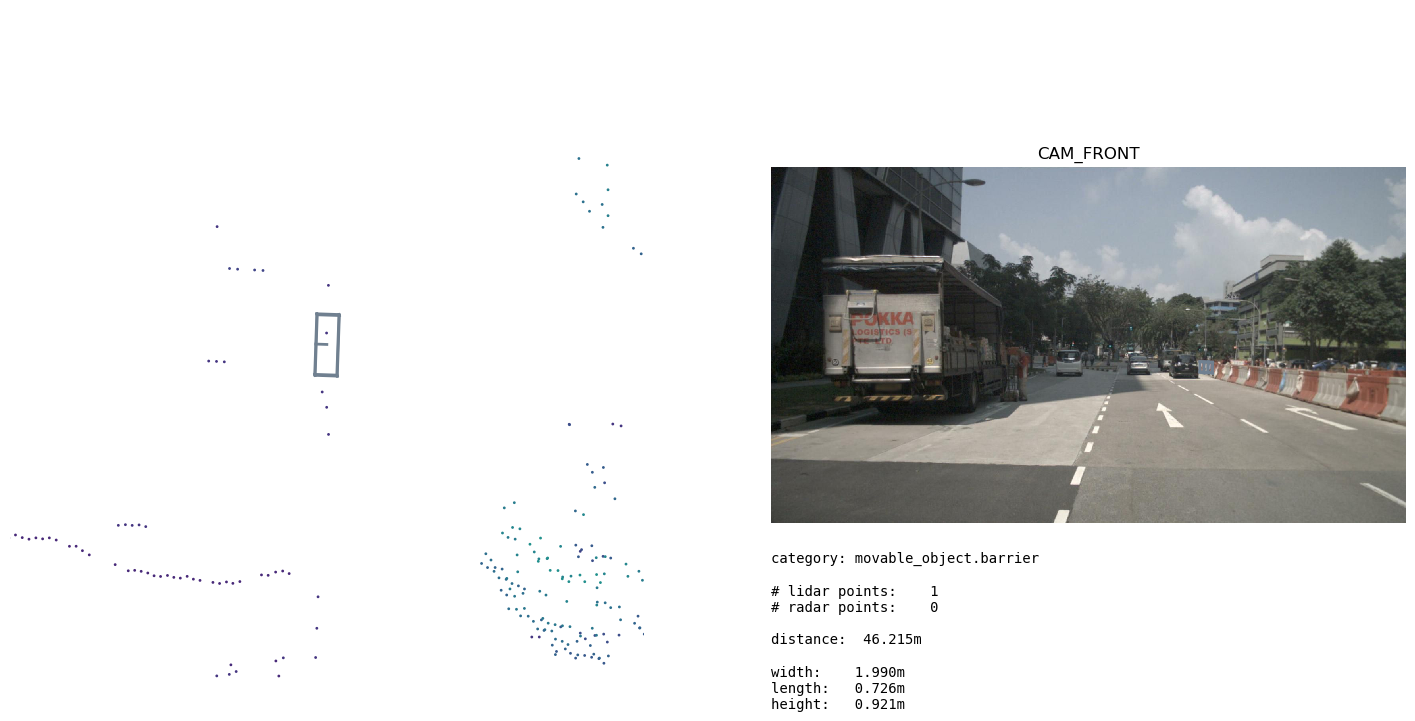

In [7]:
nusc.render_annotation(anns[29], extra_info = True)

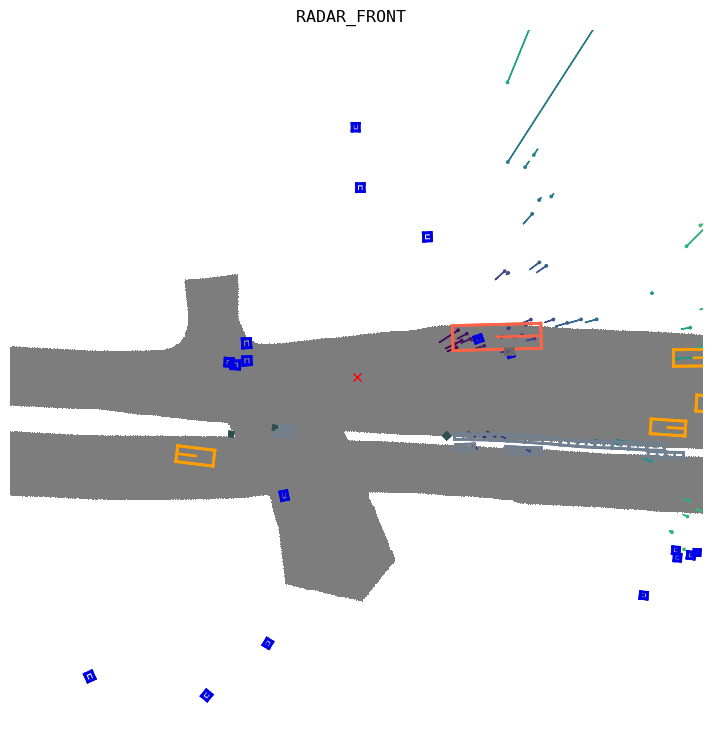

In [8]:
from nuscenes.utils.data_classes import RadarPointCloud
RadarPointCloud.disable_filters()
nusc.render_sample_data(my_sample['data']['RADAR_FRONT'], nsweeps=5, underlay_map=True)
RadarPointCloud.default_filters()

## Determining velocity of objects from RADAR points

Determining which points are within each detected object. For objects that have >1 RADAR points, determine the object velocity (mean velocity of all RADAR points detected on the object)

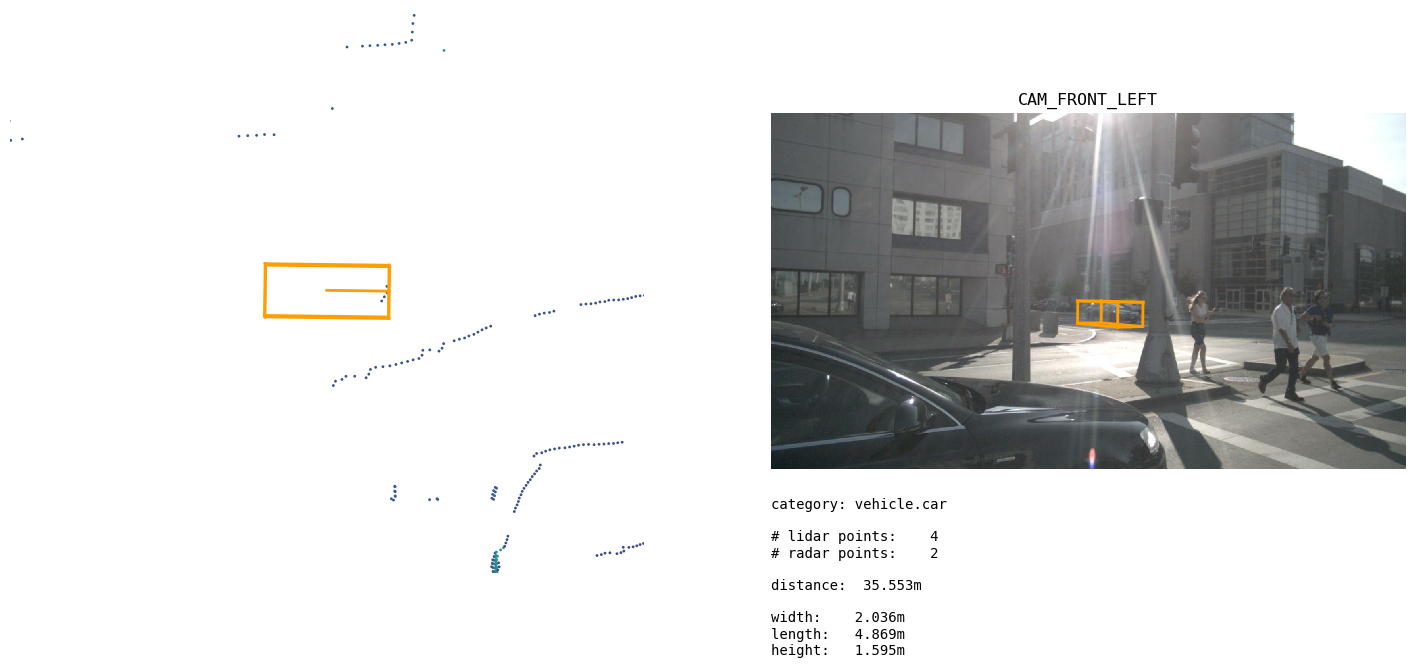

In [9]:
sensor = 'CAM_FRONT_LEFT'

# for i in range(90,110):
#     # my_sample = nusc.sample[i]
#     # anns = my_sample['anns']
#     # nusc.render_annotation(anns[29], extra_info = True)

#     my_sample = nusc.sample[i]
#     print(i)
#     cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
#     nusc.render_sample_data(cam_front_data['token'])

my_sample = nusc.sample[101]
anns = my_sample['anns']

nusc.render_annotation(anns[10], extra_info = True)

# from nuscenes.utils.data_classes import RadarPointCloud
# RadarPointCloud.disable_filters()
# nusc.render_sample_data(my_sample['data']['RADAR_FRONT'], nsweeps=5, underlay_map=True)
# RadarPointCloud.default_filters()

# sensor = 'CAM_FRONT'
# cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
# nusc.render_sample_data(cam_front_data['token'])

### Global coordinates, all RADARS

In [10]:
# List of all radar sensors in NuScenes
radar_sensors = [
    "RADAR_FRONT",
    "RADAR_FRONT_LEFT",
    "RADAR_FRONT_RIGHT",
    "RADAR_BACK_LEFT",
    "RADAR_BACK_RIGHT"
]

# Get token for sensor and annotations
my_sample = nusc.sample[0]
anns = my_sample['anns']

# Test for each individual box
for i, ann_token in enumerate(anns):
    
    num_points = 0
    all_points_inside = []  # To store points from all radar sensors
    all_velocities_inside = []
    
    # Loop through all radar sensors and collect points
    for radar_sensor in radar_sensors:

        # Retrieve RADAR token
        radar_token = my_sample['data'][radar_sensor]
        
        pointsensor = nusc.get('sample_data', radar_token)
        cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    
        # Get path in which point cloud info is stored (pc_path) and geometric information of all bounding boxes within the frame (boxes) 
        pc_path, boxes, _ = nusc.get_sample_data(radar_token, selected_anntokens=[ann_token])
        
        # Load RADAR points from retrieved path and reshape due to 5 channels
        RadarPointCloud.disable_filters()
        pc = RadarPointCloud.from_file(pc_path).points
        
        # Extract only xyz coordinates
        points = pc[:3, :]  # Shape (3, N), already transposed in RadarPointCloud 
        # print(points.shape)
    
        # Find velocity of each point within the object
        # velocities = pc[6:8, :]  # Velocities (vx, vy) 
        velocities = pc[8:10, :]  # Compensated velocities (vx_comp, vy_comp)
    
        points_inside_mask = points_in_box(boxes[0], points)  # Now points is (3, N)
        # print(points_inside.shape)
    
        points_inside = points[: , points_inside_mask]
        velocities_inside = velocities[: , points_inside_mask]

        # print(i)
        # print(radar_sensor)
        # print('Points')
        # print(points_inside.shape)
        # print(points_inside)
        # print('Velocities')
        # print(velocities_inside.shape)
        # print(velocities_inside)

        rotation = np.row_stack((velocities_inside, np.zeros(velocities_inside.shape[1])))
        rotation = Quaternion(cs_record['rotation']).rotation_matrix @ rotation
        poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
        rotation = Quaternion(poserecord['rotation']).rotation_matrix @ rotation
        
        # Add points within a box from this sensor to all sensors measured
        all_points_inside.append(points_inside)
        all_velocities_inside.append(rotation[:3,:])
        
    # Concatenante to make into numpy array    
    all_points_inside = np.concatenate(all_points_inside, axis=1)  # Shape (3, total_points)
    all_velocities_inside = np.concatenate(all_velocities_inside, axis=1)  # Shape (3, total_points)
    
    # print(all_points_inside.shape)
    # print(all_points_inside)
    
    # print(all_velocities_inside.shape)
    # print(all_velocities_inside)
    
    # For instances where all_points_inside is not empty, meaning that we have at least one RADAR point for that object
    if all_points_inside.size > 0:
        
        # Assign velocity of object by finding the mean of all RADAR point velocities
        vx_estimated_mean = np.mean(all_velocities_inside[0])
        vx_estimated_median = np.median(all_velocities_inside[0])
        vy_estimated_mean = np.mean(all_velocities_inside[1])
        vy_estimated_median = np.median(all_velocities_inside[1])    
    
            # Retrieve ground truth velocity
        velocity_gt = nusc.box_velocity(ann_token)
        vx_gt, vy_gt = velocity_gt[0], velocity_gt[1]
    
        # Helper to compute absolute difference
        def abs_diff(est, gt):
            return f"{abs(est - gt):.2f}"
    
        # Create a table
        table = [
            [
                "vx",
                f"{vx_estimated_mean:.2f} (Δ={abs_diff(vx_estimated_mean, vx_gt)})",
                f"{vx_estimated_median:.2f} (Δ={abs_diff(vx_estimated_median, vx_gt)})",
                f"{vx_gt:.2f}"
            ],
            [
                "vy",
                f"{vy_estimated_mean:.2f} (Δ={abs_diff(vy_estimated_mean, vy_gt)})",
                f"{vy_estimated_median:.2f} (Δ={abs_diff(vy_estimated_median, vy_gt)})",
                f"{vy_gt:.2f}"
            ]
        ]
        headers = ["Component", "Estimated (mean)", "Estimated (median)", "Ground Truth"]
    
        print(f"\nObject {i} velocity comparison:")
        print(tabulate(table, headers=headers, tablefmt="pretty"))
    
        # Print actual velocity and predicted velocity
        # print(f"vx of object {i}: Calculated (mean): {vx_estimated_mean}; Calculated (median): {vx_estimated_median};  Ground truth: {velocity[0]}")
        # print(f"vy of object {i}: Calculated (mean): {vy_estimated_mean}; Calculated (median): {vy_estimated_median};  Ground truth: {velocity[1]}") 


Object 7 velocity comparison:
+-----------+------------------+--------------------+--------------+
| Component | Estimated (mean) | Estimated (median) | Ground Truth |
+-----------+------------------+--------------------+--------------+
|    vx     |  -0.71 (Δ=4.68)  |   -1.17 (Δ=5.15)   |     3.97     |
|    vy     |  3.23 (Δ=5.48)   |   7.96 (Δ=0.75)    |     8.71     |
+-----------+------------------+--------------------+--------------+

Object 9 velocity comparison:
+-----------+------------------+--------------------+--------------+
| Component | Estimated (mean) | Estimated (median) | Ground Truth |
+-----------+------------------+--------------------+--------------+
|    vx     |  0.11 (Δ=0.11)   |   0.11 (Δ=0.11)    |     0.00     |
|    vy     |  0.13 (Δ=0.13)   |   0.13 (Δ=0.13)    |     0.00     |
+-----------+------------------+--------------------+--------------+

Object 11 velocity comparison:
+-----------+------------------+--------------------+--------------+
| Compone

### Vehicle coordinates & front RADAR only

This has been done to see the accuracy of tangential vs. radial velocity estimates of a RADAR sensor

In [11]:
# List of all radar sensors in NuScenes
radar_sensors = [
    "RADAR_FRONT",
]

# Get token for sensor and annotations
my_sample = nusc.sample[101]
anns = my_sample['anns']

# nusc.render_annotation(anns[17], extra_info = True)

# Test for each individual box
for i, ann_token in enumerate(anns):
    
    num_points = 0
    all_points_inside = []  # To store points from all radar sensors
    all_velocities_inside = []
    
    # Loop through all radar sensors and collect points
    for radar_sensor in radar_sensors:

        # Retrieve RADAR token
        radar_token = my_sample['data'][radar_sensor]
        
        pointsensor = nusc.get('sample_data', radar_token)
        cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    
        # Get path in which point cloud info is stored (pc_path) and geometric information of all bounding boxes within the frame (boxes) 
        pc_path, boxes, _ = nusc.get_sample_data(radar_token, selected_anntokens=[ann_token])
        
        # Load RADAR points from retrieved path and reshape due to 5 channels
        RadarPointCloud.disable_filters()
        pc = RadarPointCloud.from_file(pc_path).points
        
        # Extract only xyz coordinates
        points = pc[:3, :]  # Shape (3, N), already transposed in RadarPointCloud 
        # print(points.shape)
    
        # Find velocity of each point within the object
        # velocities = pc[6:8, :]  # Velocities (vx, vy) 
        velocities = pc[8:10, :]  # Compensated velocities (vx_comp, vy_comp)
    
        points_inside_mask = points_in_box(boxes[0], points)  # Now points is (3, N)
        # print(points_inside.shape)
    
        points_inside = points[: , points_inside_mask]
        velocities_inside = velocities[: , points_inside_mask]

        # print(i)
        # print(radar_sensor)
        # print('Points')
        # print(points_inside.shape)
        # print(points_inside)
        # print('Velocities')
        # print(velocities_inside.shape)
        # print(velocities_inside)

        rotation = np.row_stack((velocities_inside, np.zeros(velocities_inside.shape[1])))
        # rotation = Quaternion(cs_record['rotation']).rotation_matrix @ rotation
        # poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
        # rotation = Quaternion(poserecord['rotation']).rotation_matrix @ rotation
        
        # Add points within a box from this sensor to all sensors measured
        all_points_inside.append(points_inside)
        all_velocities_inside.append(rotation[:3,:])
        
    # Concatenante to make into numpy array    
    all_points_inside = np.concatenate(all_points_inside, axis=1)  # Shape (3, total_points)
    all_velocities_inside = np.concatenate(all_velocities_inside, axis=1)  # Shape (3, total_points)
    
    # print(all_points_inside.shape)
    # print(all_points_inside)
    
    # print(all_velocities_inside.shape)
    # print(all_velocities_inside)
    
    # For instances where all_points_inside is not empty, meaning that we have at least one RADAR point for that object
    if all_points_inside.size > 0:
        
        # Assign velocity of object by finding the mean of all RADAR point velocities
        vx_estimated_mean = np.mean(all_velocities_inside[0])
        vx_estimated_median = np.median(all_velocities_inside[0])
        vy_estimated_mean = np.mean(all_velocities_inside[1])
        vy_estimated_median = np.median(all_velocities_inside[1])    
        
        # Retrieve ground truth velocity
        velocity_gt = nusc.box_velocity(ann_token)[:, None]
        
        poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
        transformed_velocity_gt = Quaternion(poserecord['rotation']).rotation_matrix.T @ velocity_gt
        transformed_velocity_gt = Quaternion(cs_record['rotation']).rotation_matrix.T @ transformed_velocity_gt
        transformed_velocity_gt = transformed_velocity_gt.flatten()
        
        vx_gt, vy_gt = transformed_velocity_gt[0], transformed_velocity_gt[1]
        
        # Helper to compute absolute difference
        def abs_diff(est, gt):
            return f"{abs(est - gt):.2f}"
    
        # Create a table
        table = [
            [
                "vx",
                f"{vx_estimated_mean:.2f} (Δ={abs_diff(vx_estimated_mean, vx_gt)})",
                f"{vx_estimated_median:.2f} (Δ={abs_diff(vx_estimated_median, vx_gt)})",
                f"{vx_gt:.2f}"
            ],
            [
                "vy",
                f"{vy_estimated_mean:.2f} (Δ={abs_diff(vy_estimated_mean, vy_gt)})",
                f"{vy_estimated_median:.2f} (Δ={abs_diff(vy_estimated_median, vy_gt)})",
                f"{vy_gt:.2f}"
            ]
        ]
        headers = ["Component", "Estimated (mean)", "Estimated (median)", "Ground Truth"]
    
        print(f"\nObject {i} velocity comparison:")
        print(tabulate(table, headers=headers, tablefmt="pretty"))
    
        # Print actual velocity and predicted velocity
        # print(f"vx of object {i}: Calculated (mean): {vx_estimated_mean}; Calculated (median): {vx_estimated_median};  Ground truth: {velocity[0]}")
        # print(f"vy of object {i}: Calculated (mean): {vy_estimated_mean}; Calculated (median): {vy_estimated_median};  Ground truth: {velocity[1]}") 


Object 0 velocity comparison:
+-----------+------------------+--------------------+--------------+
| Component | Estimated (mean) | Estimated (median) | Ground Truth |
+-----------+------------------+--------------------+--------------+
|    vx     |  -0.81 (Δ=0.64)  |   -0.81 (Δ=0.64)   |    -0.17     |
|    vy     |  -1.08 (Δ=0.47)  |   -1.08 (Δ=0.47)   |    -1.55     |
+-----------+------------------+--------------------+--------------+

Object 4 velocity comparison:
+-----------+------------------+--------------------+--------------+
| Component | Estimated (mean) | Estimated (median) | Ground Truth |
+-----------+------------------+--------------------+--------------+
|    vx     |  0.00 (Δ=0.00)   |   0.00 (Δ=0.00)    |    -0.00     |
|    vy     |  0.00 (Δ=0.01)   |   0.00 (Δ=0.01)    |     0.01     |
+-----------+------------------+--------------------+--------------+

Object 10 velocity comparison:
+-----------+------------------+--------------------+--------------+
| Compone